In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit


from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import make_scorer

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator



import datetime

from sklearn import set_config
set_config(display='diagram') 

plt.rcParams['figure.figsize'] = [20, 20]

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("poster")
sns.set_style("white")
palette = sns.color_palette("mako_r", 6)

In [4]:
def import_data():
    # charging session data 
    
    df1 = pd.read_csv('data/Fort Collins Utilities EV Data June 2020 to June 2021.csv')
    
    df2 = pd.read_csv('data/Fort Collins Utilities EV Data June 25 2021 to July 20 2021.csv')
   
    #df3 = pd.read_csv('data/FCU EV Charging Transaction Data July 20 2021 to Sept 2021.csv')
    
    return pd.concat([df1, df2, df3])

In [39]:
df = import_data()

In [59]:
df = (df.rename(columns={'Session/Reservation Start Date': 'Date'})
        .dropna(how='all')
        .assign(date=lambda x: x['Date'])
     )

In [60]:
df = df.set_index(pd.to_datetime(df['Date']))

# Prepare the dataframe for modeling

In [62]:
df2 = (df[['Energy (kWh)', 'Net Revenue']]
       .resample('1D')
       .sum()
       .reset_index()
       .set_index('Date')
)

In [65]:
df2["Energy (kWh)_7D"] = df2['Energy (kWh)'].\
                         transform(lambda x: x.rolling(7, min_periods=7, closed='both', center=True).median())
df2["Net Revenue_7D"] = df2['Net Revenue'].\
                         transform(lambda x: x.rolling('7D', min_periods=7, closed='both', center=True).median())

df2['Energy (kWh)_7D'] = df2['Energy (kWh)_7D'].interpolate(method='linear', limit_direction='both')
df2['Net Revenue_7D'] = df2['Net Revenue_7D'].interpolate(method='linear', limit_direction='both')

In [66]:
# forecast with Prophet

In [67]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [68]:
df_ = df2.rename(columns={'Net Revenue_7D':'y', 'Start Date':'ds'})
df_['ds'] = df_.index

In [69]:
df_['ds'] = df_.index

In [70]:
df_.head()

,Energy (kWh),Net Revenue,Energy (kWh)_7D,y,ds
Date,,,,,
2020-06-25,30.023,4.41,8.058,3.61,2020-06-25
2020-06-26,20.714,3.66,8.058,3.61,2020-06-26
2020-06-27,24.199,3.61,8.058,3.61,2020-06-27
2020-06-28,8.058,1.19,8.058,3.61,2020-06-28
2020-06-29,6.977,5.79,8.075,1.80,2020-06-29


In [71]:
def is_stay_at_home(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.Timestamp(2020,3,25) and date < pd.Timestamp(2020,4,26))

df_['is_stay_at_home'] = df_['ds'].apply(is_stay_at_home)
df_['is_not_stay_at_home'] = ~df_['ds'].apply(is_stay_at_home)

In [72]:
def create_end_of_year_holidays_df():
    """Create holidays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2019-12-25', '2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays

In [73]:
changepoints = ['2020-07-01', '2020-09-20', '2020-11-01', '2021-02-05', '2021-03-24', '2021-05-02']


In [74]:
def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holidays_df()
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
        changepoints=changepoints, 

    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=10
    )

    
    model.add_seasonality(
        name='stay_at_home', 
        period=7, 
        fourier_order=30, 
        condition_name='is_stay_at_home'
    )
    model.add_seasonality(
        name='no_stay_at_home', 
        period=7, 
        fourier_order=30, 
        condition_name='is_not_stay_at_home')
    
    return model
    
model = build_model()


In [75]:
model.fit(df_)

In [76]:
future = model.make_future_dataframe(periods=1500)
future['is_stay_at_home'] = future['ds'].apply(is_stay_at_home)
future['is_not_stay_at_home'] = ~future['ds'].apply(is_stay_at_home)
forecast = model.predict(future)

In [77]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,end_of_year,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-25,2.860542,-2.050006,7.311571,2.860542,2.860542,-0.510850,-0.510850,-0.510850,0.0,...,-0.012403,-0.012403,-0.012403,2.741456,2.741456,2.741456,0.0,0.0,0.0,2.349692
1,2020-06-26,2.906395,-2.261467,7.191907,2.906395,2.906395,-0.302259,-0.302259,-0.302259,0.0,...,-0.005308,-0.005308,-0.005308,2.637658,2.637658,2.637658,0.0,0.0,0.0,2.604137
2,2020-06-27,2.952248,-2.480338,6.879849,2.952248,2.952248,-0.415107,-0.415107,-0.415107,0.0,...,-0.017049,-0.017049,-0.017049,2.523838,2.523838,2.523838,0.0,0.0,0.0,2.537141
3,2020-06-28,2.998102,-2.190895,7.150902,2.998102,2.998102,-0.379550,-0.379550,-0.379550,0.0,...,-0.005609,-0.005609,-0.005609,2.403394,2.403394,2.403394,0.0,0.0,0.0,2.618552
4,2020-06-29,3.043955,-1.957322,7.308376,3.043955,3.043955,-0.484374,-0.484374,-0.484374,0.0,...,0.012468,0.012468,0.012468,2.279859,2.279859,2.279859,0.0,0.0,0.0,2.559581


In [78]:
from prophet.plot import add_changepoints_to_plot

[[<matplotlib.lines.Line2D at 0x7ff91684a0d0>]]

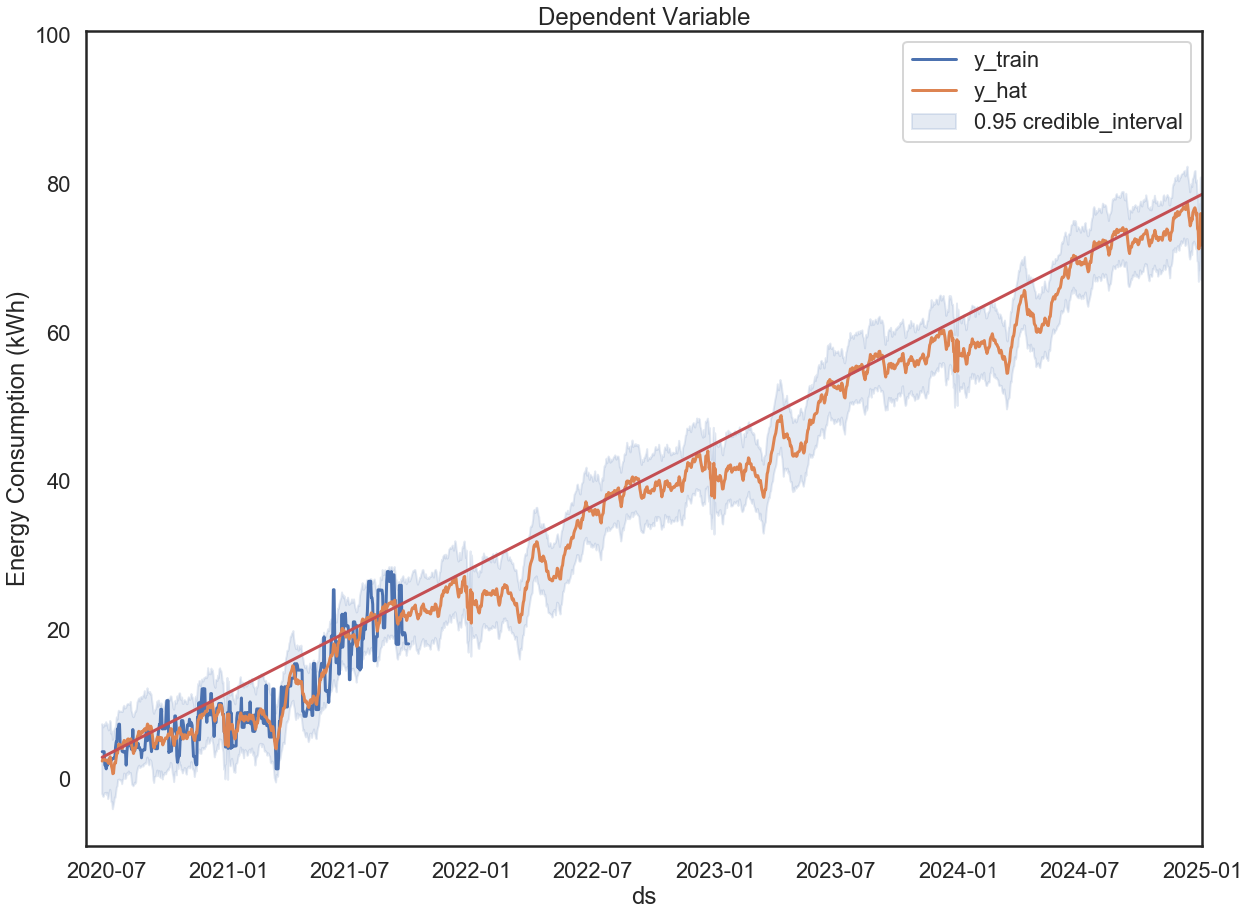

In [79]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color='b', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)

ax.legend(loc='upper right')
ax.set(title='Dependent Variable', ylabel='Energy Consumption (kWh)');
ax.set_xlim(xmin=datetime.datetime(2020, 6, 1),xmax=datetime.datetime(2025, 1, 1))

#ax.plot(forecast['yhat'].cumsum())
# for changepoint in model.changepoints:
#     plt.axvline(changepoint,ls='--', lw=1)
    
add_changepoints_to_plot(ax, model, forecast)

In [705]:
forecast['cumsum_revenue_prediction'] = forecast['yhat'].cumsum()
forecast['cumsum_revenue_prediction_upper'] = forecast['yhat_upper'].cumsum()

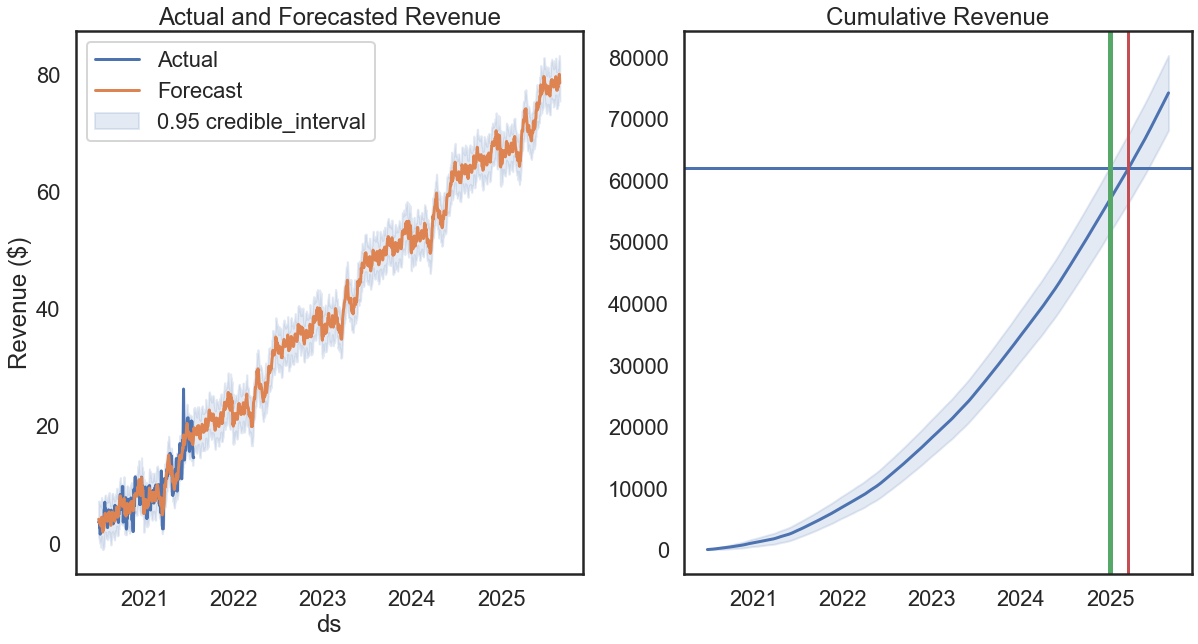

In [706]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
plt.plot(forecast.ds, forecast['cumsum_revenue_prediction'])
#ax2.axhline(y=41000)
ax2.axhline(y=62077)
ax2.axvline(x=datetime.datetime(2025, 3, 16), color='r')
ax2.axvline(x=datetime.datetime(2025, 1, 1), color='g', lw=5)

ax1.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color='b', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='Actual', data=df_, ax=ax1)
sns.lineplot(x='ds', y='yhat', label='Forecast', data=forecast, ax=ax1)
ax1.set_ylabel('Revenue ($)')

ax1.set_title('Actual and Forecasted Revenue')
ax2.set_title('Cumulative Revenue')


ax2.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'].cumsum(),
    y2=forecast['yhat_upper'].cumsum(),
    color='b', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)

In [707]:
# find the date at which cumulative revenue reaches $21,077 + $41,000
forecast[forecast['cumsum_revenue_prediction'] >=  62077].iloc[0]['ds']

Timestamp('2025-03-19 00:00:00')

In [859]:
forecast[forecast['ds'] == datetime.datetime(2025, 1, 1)]['cumsum_revenue_prediction']


1651    58574.294283
Name: cumsum_revenue_prediction, dtype: float64

In [860]:
forecast2[forecast2['ds'] == datetime.datetime(2025, 1, 1)]['cumsum_revenue_prediction']


1651    67497.330152
Name: cumsum_revenue_prediction, dtype: float64

# They only just make the target. Can we reach our target before the target date if we increase our hourly-rate for charging?

### Get the hourly rate for EV charging

In [1040]:
df = import_data()

In [1041]:
df = df.assign(start_date=lambda df: pd.to_datetime(df["Session/Reservation Start Date"]))
df = df.assign(end_date=lambda df: pd.to_datetime(df["Session/Reservation End Date"].str[:-5]))

In [1043]:
df = df.dropna(how='all')

In [1044]:
def get_revenue(x):
    hours = (x['end_date'] - x['start_date'])/ np.timedelta64(1, 'h')
    return hours * 1.1 # 10 cents/hour increase

In [1045]:

df['new_net_revenue'] = df.apply(lambda x: get_revenue(x), axis = 1)

In [1046]:
df = df.set_index('start_date')

# Now project the revenue using this new hourly rate

In [1047]:
df2 = (df[['Energy (kWh)', 'Net Revenue', 'new_net_revenue']]
       .resample('1D')
       .sum()
       .reset_index()
       .set_index('start_date')
)

In [1048]:
df2["Current Net Revenue_7D"] = df2['Net Revenue'].\
                         transform(lambda x: x.rolling(7, min_periods=7, closed='both', center=True).median())
df2["New Net Revenue_7D"] = df2['new_net_revenue'].\
                         transform(lambda x: x.rolling(7, min_periods=7, closed='both', center=True).median())

df2["current Net Revenue_7D"] = df2["Current Net Revenue_7D"].interpolate(method='linear', limit_direction='both')
df2["New Net Revenue_7D"] = df2["New Net Revenue_7D"].interpolate(method='linear', limit_direction='both')

In [1049]:
df_ = df2.rename(columns={'Current Net Revenue_7D':'y', 'Start Date':'ds'})
df_['ds'] = df_.index

df_['is_stay_at_home'] = df_['ds'].apply(is_stay_at_home)
df_['is_not_stay_at_home'] = ~df_['ds'].apply(is_stay_at_home)

In [1050]:
model = build_model()
model.fit(df_)

In [1051]:
future = model.make_future_dataframe(periods=1500)
future['is_stay_at_home'] = future['ds'].apply(is_stay_at_home)
future['is_not_stay_at_home'] = ~future['ds'].apply(is_stay_at_home)
forecast = model.predict(future)

In [1052]:
forecast['cumsum_revenue_prediction'] = forecast['yhat'].cumsum()
forecast['cumsum_revenue_prediction_upper'] = forecast['yhat_upper'].cumsum()

In [1053]:
df_ = df2.rename(columns={'New Net Revenue_7D':'y', 'Start Date':'ds'})
df_['ds'] = df_.index

df_['is_stay_at_home'] = df_['ds'].apply(is_stay_at_home)
df_['is_not_stay_at_home'] = ~df_['ds'].apply(is_stay_at_home)

In [1054]:
model = build_model()
model.fit(df_)

In [1055]:
future = model.make_future_dataframe(periods=1500)
future['is_stay_at_home'] = future['ds'].apply(is_stay_at_home)
future['is_not_stay_at_home'] = ~future['ds'].apply(is_stay_at_home)
forecast2 = model.predict(future)

In [1056]:
forecast2['cumsum_revenue_prediction'] = forecast2['yhat'].cumsum()
forecast2['cumsum_revenue_prediction_upper'] = forecast2['yhat_upper'].cumsum()

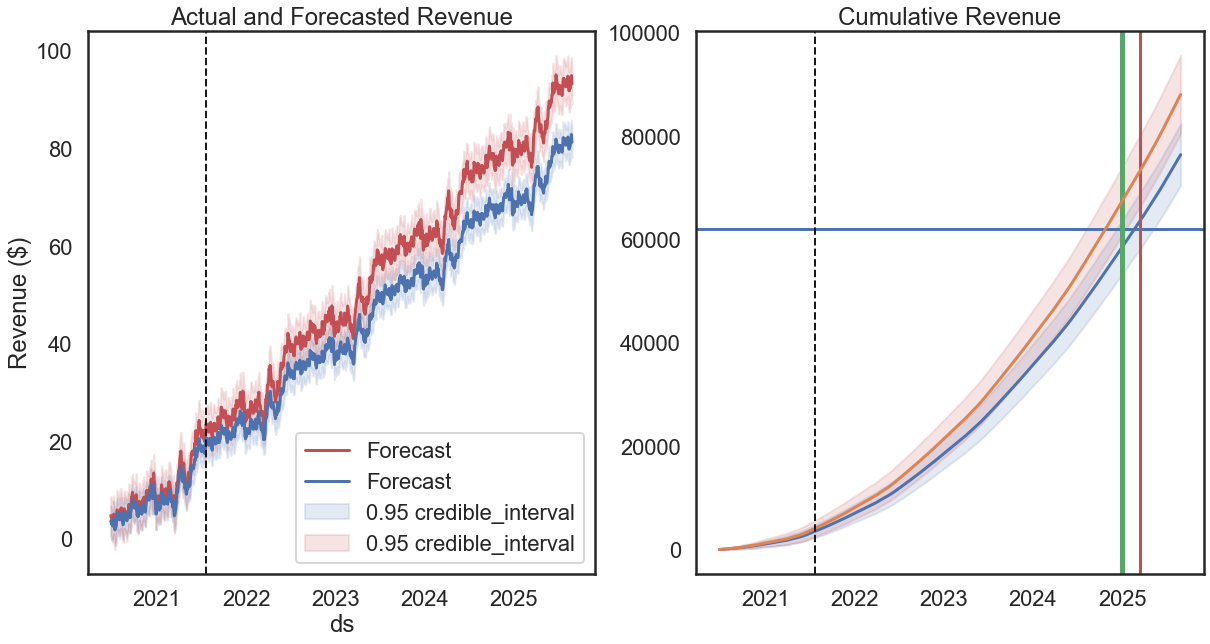

In [1057]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax2.plot(forecast.ds, forecast['cumsum_revenue_prediction'])
#ax2.axhline(y=41000)
ax2.axhline(y=62077)
ax2.axvline(x=datetime.datetime(2025, 3, 16), color='r')
ax2.axvline(x=datetime.datetime(2025, 1, 1), color='g', lw=5)

ax1.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color='b', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)

ax1.fill_between(
    x=forecast2['ds'],
    y1=forecast2['yhat_lower'],
    y2=forecast2['yhat_upper'],
    color='r', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)
sns.lineplot(x='ds', y='yhat', label='Forecast', data=forecast2, ax=ax1, color='r')
#sns.lineplot(x='ds', y='y', label='Actual', data=df_, ax=ax1, color='r')
sns.lineplot(x='ds', y='yhat', label='Forecast', data=forecast, ax=ax1, color='b')
ax1.set_ylabel('Revenue ($)')

ax1.set_title('Actual and Forecasted Revenue')
ax2.set_title('Cumulative Revenue')


ax2.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'].cumsum(),
    y2=forecast['yhat_upper'].cumsum(),
    color='b', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)

ax2.plot(forecast2.ds, forecast2['cumsum_revenue_prediction'])
ax2.fill_between(
    x=forecast2['ds'],
    y1=forecast2['yhat_lower'].cumsum(),
    y2=forecast2['yhat_upper'].cumsum(),
    color='r', 
    alpha=0.15,
    label=r'0.95 credible_interval'
)

ax1.axvline(x=datetime.datetime(2021, 7, 20), color='k', lw=2, ls='--')
ax2.axvline(x=datetime.datetime(2021, 7, 20), color='k', lw=2, ls='--')

In [1058]:
time_to_target_current = forecast[forecast['cumsum_revenue_prediction'] >=  62077].iloc[0]['ds']


In [1059]:
time_to_target_current

Timestamp('2025-02-21 00:00:00')

In [1060]:
time_to_target_new = forecast2[forecast2['cumsum_revenue_prediction'] >=  62077].iloc[0]['ds']

In [1061]:
time_to_target_new

Timestamp('2024-10-25 00:00:00')

In [1062]:
duration = time_to_target_new - time_to_target_current

In [1063]:
f"By increasing hourly charging rate by $0.11, you are projected to reach $62,077 {abs(duration.days)} days sooner."

'By increasing hourly charging rate by $0.11, you are projected to reach $62,077 119 days sooner.'

In [1065]:
old_revenue2025 = forecast[forecast['ds'] == datetime.datetime(2025, 1, 1)]['cumsum_revenue_prediction']
new_revenue2025 = forecast2[forecast2['ds'] == datetime.datetime(2025, 1, 1)]['cumsum_revenue_prediction']

savings = new_revenue2025 - old_revenue2025

In [1066]:
new_revenue2025 - 62077

1651    5420.330152
Name: cumsum_revenue_prediction, dtype: float64

In [987]:
savings.iloc[0]

2694.2528754559316

In [988]:
f"By increasing hourly charging rate by $0.20, you are projected to increase revenue at the end of grant period by ${savings.iloc[0]:.2f}"

'By increasing hourly charging rate by $0.20, you are projected to increase revenue at the end of grant period by $2694.25'

In [990]:
62077 - old_revenue2025

1651    3502.705717
Name: cumsum_revenue_prediction, dtype: float64

In [989]:
forecast \
    .set_index('ds') \
    .resample('3M').asfreq().pad()['cumsum_revenue_prediction'][:"2025-04-01"] \
    .reset_index() \
    .set_index('ds').T

ds,2020-06-30,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31
cumsum_revenue_prediction,20.027733,446.290907,1112.251678,1822.111045,3118.649554,4957.310329,7037.00373,9128.259585,11821.364416,15072.839237,18566.284715,22038.691811,26128.293459,30792.57498,35699.965207,40611.475575,46104.089952,52185.01746,58506.262748,64746.390387


In [888]:
import json
from prophet.serialize import model_to_json, model_from_json


###  Save the model

In [930]:
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

### Load the model

In [894]:
with open('serialized_model.json', 'r') as fin:
    model = model_from_json(json.load(fin))  # Load model


In [895]:
model

In [932]:
forecast_quarter = (forecast 
                        .set_index('ds') 
                        .resample('3M').asfreq().pad()['cumsum_revenue_prediction'][:"2025-04-01"] 
                        .reset_index() 
)

forecast_quarter = (forecast_quarter
                                .assign(ds=lambda df: pd.to_datetime(df["ds"]))
                                .assign(ds=lambda df: df["ds"].dt.strftime('%m/%d/%Y'))
                                .set_index('ds')
                    ).T

In [933]:
forecast_quarter

ds,06/30/2020,09/30/2020,12/31/2020,03/31/2021,06/30/2021,09/30/2021,12/31/2021,03/31/2022,06/30/2022,09/30/2022,12/31/2022,03/31/2023,06/30/2023,09/30/2023,12/31/2023,03/31/2024,06/30/2024,09/30/2024,12/31/2024,03/31/2025
cumsum_revenue_prediction,20.027733,446.290907,1112.251678,1822.111045,3118.649554,4957.310329,7037.00373,9128.259585,11821.364416,15072.839237,18566.284715,22038.691811,26128.293459,30792.57498,35699.965207,40611.475575,46104.089952,52185.01746,58506.262748,64746.390387


In [934]:
forecast[forecast['cumsum_revenue_prediction'] >=  62077].iloc[0]['ds']

Timestamp('2025-02-21 00:00:00')